In [ ]:
"""parameters: c, kernel, gamma
c: default: 1
kernel: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. default: ‘rbf’
gamma - rbf, poly, sigmoid
"""

In [16]:
#introduction to machinelearning with python p87 
# https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
#from sklearn.learning_curve import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc

from time import time
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

#from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify = cancer.target, random_state=0)

svc_clf = SVC(gamma = 'auto')
svc_clf.fit(X_train, y_train)
print("SVC train score: {:.3f}".format(svc_clf.score(X_train, y_train)))
print("SVC test score: {:.3f}".format(svc_clf.score(X_test, y_test)))
print(svc_clf.get_params)

y_pred = svc_clf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("SVC AUC score: {:.3f}".format(roc_auc))

SVC train score: 1.000
SVC test score: 0.629
<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
SVC AUC score: 0.500


In [2]:
#scaling
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)
X_train_scaled = (X_train - mean_train)/std_train
X_test_scaled = (X_test - mean_train)/std_train

svc_scaled = SVC(random_state = 0)
svc_scaled.fit(X_train_scaled, y_train)
print("SVC-Scaled train score: {:.3f}".format(svc_scaled.score(X_train_scaled, y_train)))
print("SVC-Scaled test score: {:.3f}".format(svc_scaled.score(X_test_scaled, y_test)))
y_pred = svc_scaled.predict(X_test_scaled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("SVC-Scaled AUC score: {:.3f}".format(roc_auc))

SVC-Scaled train score: 0.993
SVC-Scaled test score: 0.958
SVC-Scaled AUC score: 0.955


In [28]:
print("-----------------------")
svc_scaled_final = SVC(gamma = 'auto', random_state = 0)
start = time()
svc_scaled_final.fit(X_train_scaled, y_train)
print("time took: %.3f seconds "%(time() - start))  #after fitting
print("SVC-Scaled final score - training (tanh, sgd, alpha:) : {:.3f}".format(svc_scaled_final.score(X_train_scaled, y_train)))
print("SVC-Scaled final score - test (tanh, sgd, alpha:) : {:.3f}".format(svc_scaled_final.score(X_test_scaled, y_test)))
print("-----------------------")

y_pred = svc_scaled_final.predict(X_train_scaled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("SVC-Scaled final AUC score - training set: {:.3f}".format(roc_auc))

y_pred = svc_scaled_final.predict(X_test_scaled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("SVC-ScaledP final AUC score - test set: {:.3f}".format(roc_auc))

-----------------------
time took: 0.005 seconds 
SVC-Scaled final score - training (tanh, sgd, alpha:) : 0.993
SVC-Scaled final score - test (tanh, sgd, alpha:) : 0.958
-----------------------
SVC-Scaled final AUC score - training set: 0.992
SVC-ScaledP final AUC score - test set: 0.955


In [3]:
print(svc_scaled.get_params)

<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)>


### Grid Search

In [19]:
#grid search v. randomize search
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")   

#---------------------------------------------------------------------------------------------
param_grid = {'C': 10.0 ** np.arange(-3, 2),
              'kernel': [ 'poly', 'rbf', 'sigmoid'], #'linear', 'precomputed'
              'gamma':  10.0 ** np.arange(-3, 0)}
             #'gamma': ['auto']}
            
grid_search = GridSearchCV(svc_scaled, param_grid = param_grid, cv = 5)
start = time()
grid_search.fit(X_train_scaled, y_train)
print("***GridSearchCV took %.2f seconds for %d candidates parameter settings."
      %((time() - start), len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)
print(param_grid)

***GridSearchCV took 2.42 seconds for 45 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.979 (std: 0.009)
Parameters: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.977 (std: 0.013)
Parameters: {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.972 (std: 0.014)
Parameters: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': array([0.001, 0.01 , 0.1  ])}


c:\users\nfleming\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Validation Curve


[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5]


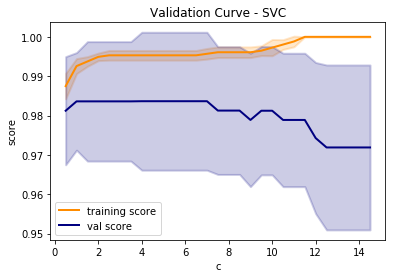

[0.98748086 0.99256787 0.99374097 0.99491406 0.99530653 0.99530653
 0.99530653 0.99530653 0.99530653 0.99530653 0.99530653 0.99530653
 0.99530653 0.99569792 0.99608824 0.99608824 0.99608824 0.99608824
 0.99647963 0.99726348 0.99804519 0.99882797 1.         1.
 1.         1.         1.         1.         1.        ]
[0.98122435 0.9836053  0.9836053  0.9836053  0.9836053  0.9836053
 0.9836053  0.98364433 0.98364433 0.98364433 0.98364433 0.98364433
 0.98364433 0.98364433 0.98126338 0.98126338 0.98126338 0.97888243
 0.98122435 0.98122435 0.97888243 0.97888243 0.97888243 0.97427413
 0.97189318 0.97189318 0.97189318 0.97189318 0.97189318]


In [27]:
#gamma =  np.arange ( 0.001, 0.101, 0.001)
c=  np.arange ( 0.5, 15, 0.5)
training_score, val_score = validation_curve(SVC(gamma = 'auto', random_state = 0),  
                                             X_train_scaled, y_train,
                                             param_name = "C", 
                                             param_range = c, cv= 7)
print(c)

train_score_mean = np.mean(training_score, 1)
train_score_std = np.std(training_score, 1)
val_score_mean = np.mean(val_score, 1)
val_score_std = np.std(val_score, 1)
plt.title("Validation Curve - SVC") 
plt.xlabel("c")
plt.ylabel("score")
#plt.ylim(0.9,1)
lw = 2
plt.plot(c, train_score_mean, label = 'training score', color = 'darkorange', lw = lw)
plt.fill_between(c, 
                 train_score_mean - train_score_std,
                 train_score_mean + train_score_std,
                 alpha = 0.2, color = 'darkorange', lw = lw)           
plt.plot(c, val_score_mean, label = 'val score', color = 'navy', lw = lw)
plt.fill_between(c, 
                 val_score_mean - val_score_std,
                 val_score_mean + val_score_std,
                 alpha = 0.2, color = 'navy', lw = lw) 
plt.legend()
plt.show()    
print(train_score_mean)
print(val_score_mean)

[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024
 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033 0.034 0.035 0.036
 0.037 0.038 0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.047 0.048
 0.049 0.05  0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059 0.06
 0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071 0.072
 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083 0.084
 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095 0.096
 0.097 0.098 0.099 0.1  ]


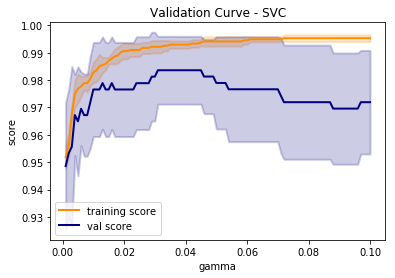

[0.95188361 0.95618463 0.96752423 0.97495421 0.97691009 0.97769609
 0.97887241 0.97887134 0.98043583 0.9827831  0.98356481 0.98513144
 0.98552283 0.98591422 0.98708947 0.98787332 0.98865503 0.98904749
 0.99022274 0.99061306 0.99061306 0.99100338 0.99100338 0.99100338
 0.99100338 0.99178509 0.99178509 0.99178509 0.99217648 0.99217648
 0.99217648 0.99217648 0.99256787 0.99256787 0.99295926 0.99295926
 0.99295926 0.99295926 0.99295926 0.99295926 0.99295926 0.99335065
 0.99335065 0.99335065 0.99374097 0.99413235 0.99413235 0.99413235
 0.99413235 0.99413235 0.99413235 0.99413235 0.99413235 0.99413235
 0.99413235 0.99413235 0.99413235 0.99413235 0.99452374 0.99452374
 0.99491406 0.99491406 0.99491406 0.99491406 0.99491406 0.99491406
 0.99491406 0.99491406 0.99491406 0.99491406 0.99491406 0.99530653
 0.99530653 0.99530653 0.99530653 0.99530653 0.99530653 0.99530653
 0.99530653 0.99530653 0.99530653 0.99530653 0.99530653 0.99530653
 0.99530653 0.99530653 0.99530653 0.99530653 0.99530653 0.9953

In [26]:
gamma =  np.arange ( 0.001, 0.101, 0.001)
#c=  np.arange ( 0.5, 15, 0.5)
training_score, val_score = validation_curve(SVC(random_state = 0),  
                                             X_train_scaled, y_train,
                                             param_name = "gamma", 
                                             param_range = gamma, cv= 7)
print(gamma)

train_score_mean = np.mean(training_score, 1)
train_score_std = np.std(training_score, 1)
val_score_mean = np.mean(val_score, 1)
val_score_std = np.std(val_score, 1)
plt.title("Validation Curve - SVC") 
plt.xlabel("gamma")
plt.ylabel("score")
#plt.ylim(0.9,1)
lw = 2
plt.plot(gamma, train_score_mean, label = 'training score', color = 'darkorange', lw = lw)
plt.fill_between(gamma, 
                 train_score_mean - train_score_std,
                 train_score_mean + train_score_std,
                 alpha = 0.2, color = 'darkorange', lw = lw)           
plt.plot(gamma, val_score_mean, label = 'val score', color = 'navy', lw = lw)
plt.fill_between(gamma, 
                 val_score_mean - val_score_std,
                 val_score_mean + val_score_std,
                 alpha = 0.2, color = 'navy', lw = lw) 
plt.legend()
plt.show()    
print(train_score_mean)
print(val_score_mean)

### Learning Curve

<module 'matplotlib.pyplot' from 'c:\\users\\nfleming\\appdata\\local\\programs\\python\\python37-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

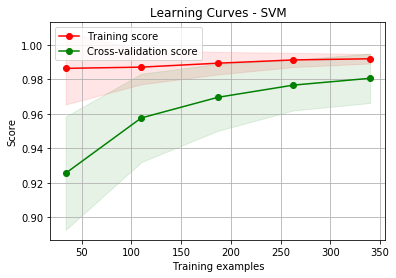

In [32]:
#learning curve
def plot_learning_curve (estimator, title, X,y, ylim = None, cv = None, 
                         n_jobs = None, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim (*ylim)
    plt.xlabel ("Training examples")
    plt.ylabel ("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1, color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "Cross-validation score")
    plt.legend(loc ="best")
    return plt

X, y = X_train_scaled, y_train

title = "Learning Curves - SVM"
cv = ShuffleSplit(n_splits = 100, test_size = 0.2, random_state = 1)
estimator = svc_scaled_final
plot_learning_curve(estimator, title, X, y, cv = cv, n_jobs = 4)